# Optical Coherence Tomography Image Classification

There is always a shortage of medical professionals that can reliably analyze imaging data to provide accurate diagnoses. Fortunately, there has been reasonable success in training deep learning models to assist in these tasks and help identify diseases that might escape the notice of a physician. In this tutorial, I want to go over the basics of the use of convolutional neural networks in the identification and diagnosis of diseases from medical imaging data. 


In [ ]:
%load_ext autoreload
%autoreload 1
%matplotlib inline

# Import packages
import numpy as np
import os
import tensorflow as tf
import matplotlib
from matplotlib import pyplot as plt
from skimage.color import gray2rgb
from skimage.transform import resize
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense, Conv2D, MaxPooling2D, BatchNormalization 

In [2]:
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

The dataset used contains 84,495 images belonging to 4 different classes: Healthy retinas (NORMAL), choroidal neovascularization (CNV), diabetic macular edema(DNE), and multiple drusen (DRUSEN). The dataset can be found here: https://data.mendeley.com/datasets/rscbjbr9sj/2. 

The code below can help load in the imaging data.

In [49]:
def get_images(N, class_name, root_folder):
    images = []
    for root, dir, files in os.walk(root_folder):
        if root.split(os.sep)[-1] == class_name:
            for i, file in enumerate(files):
                # print(i)
                if file.endswith('.jpeg'):
                    images.append(plt.imread(os.path.join(root,file)))
                if i+1 == N:
                    return images
    return images

#### Data Visualization
Let’s take a look at example data and visualize its distribution.

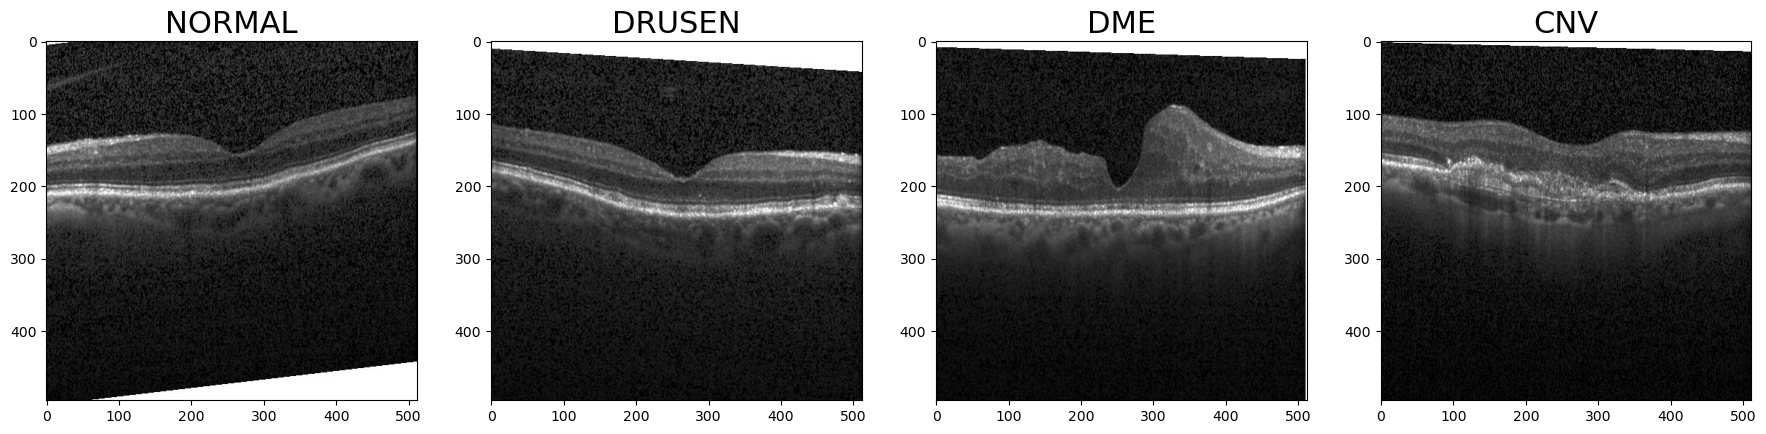

In [51]:
N = 1
folder     = os.path.join('.', 'archive', 'OCT2017', 'train')
CNVimages  = get_images(N, 'CNV', folder)
DMEimages  = get_images(N, 'DME', folder)
DRUSENimages  = get_images(N, 'DRUSEN', folder)
NORMALimages  = get_images(N, 'NORMAL', folder)

fig, axs = plt.subplots(1, 4, figsize=(22,5))

ax = axs[3]
ax.set_title("CNV", fontsize=22)
ax.imshow(gray2rgb(CNVimages[0]))

ax = axs[2]
ax.set_title("DME", fontsize=22)
ax.imshow(gray2rgb(DMEimages[0]))

ax = axs[1]
ax.set_title("DRUSEN", fontsize=22)
ax.imshow(gray2rgb(DRUSENimages[0]))

ax = axs[0]
ax.set_title("NORMAL", fontsize=22)
ax.imshow(gray2rgb(NORMALimages[0]))

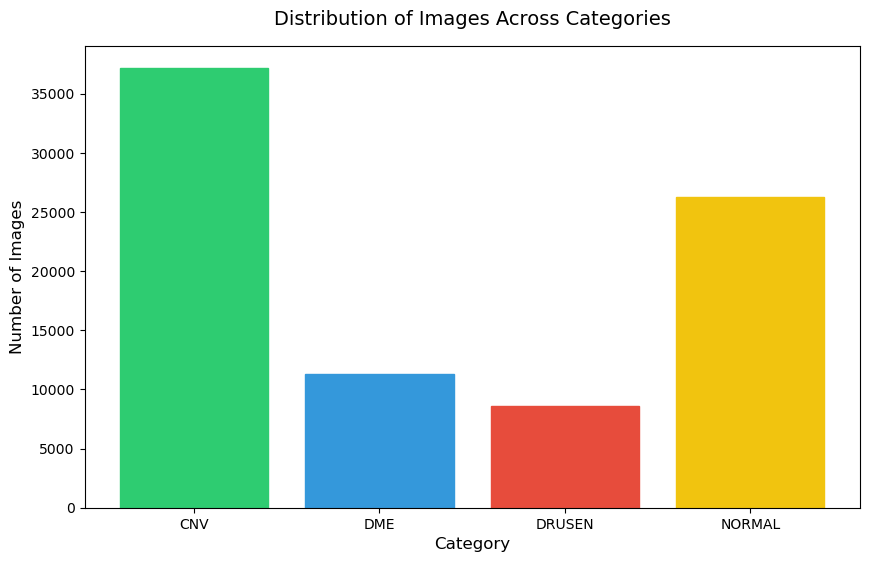

In [29]:
# Calculate the number of images in each category
counts = {
    'CNV': len(CNVimages),
    'DME': len(DMEimages),
    'DRUSEN': len(DRUSENimages),
    'NORMAL': len(NORMALimages)
}

# Create bar plot
plt.figure(figsize=(10, 6))
bars = plt.bar(counts.keys(), counts.values())

# Customize the plot
plt.title('Distribution of Images Across Categories', fontsize=14, pad=15)
plt.xlabel('Category', fontsize=12)
plt.ylabel('Number of Images', fontsize=12)
colors = ['#2ecc71', '#3498db', '#e74c3c', '#f1c40f']
for bar, color in zip(bars, colors):
    bar.set_color(color)

#### Data Augmentation
To help reduce overfitting, we can add a data augmentation pipeline. Here we scale the pixel values, and add in random horizontal flip, rotation, and zoom tranformations to diversify our training data.

In [ ]:
t_transform = ImageDataGenerator(
    rescale=1./255,
    horizontal_flip=True,
    rotation_range=30,
    zoom_range=0.2,
    fill_mode='nearest'
)

v_transform = ImageDataGenerator(
    rescale=1/255,
    fill_mode='nearest'
)

#### Model
Here we specify our training and validation datasets, and define our hyperameters. Hyperameters should be adjusted to achieve the highest possible testing accuracy after we train the model

In [ ]:
classes = ['CNV', 'DME', 'DRUSEN', 'NORMAL']
num_classes = 4
dims = (224, 224)
batch_size = 512
num_epochs = 10  

train_generator = t_transform.flow_from_directory(
  os.path.join('.', 'archive', 'OCT2017', 'train'),
  target_size = dims,
  batch_size = batch_size,
  class_mode = 'categorical',
  shuffle = True
)

validation_generator = v_transform.flow_from_directory(
  os.path.join('.', 'archive', 'OCT2017', 'val'),
  target_size = dims,
  batch_size = batch_size,
  class_mode = 'categorical',
  shuffle = True
)

Now let's take a look at the model architecture. This is a custom convolutional neural network architecture that works well on the data, but undoubtably able to be achieved by larger, more state-of-the-art model architectures.

In [ ]:
model = models.Sequential()
model.add(layers.Conv2D(16, (3, 3), activation='relu', input_shape=(dims[0], dims[1], 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.BatchNormalization())
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(dims[0], dims[1], 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.BatchNormalization())
model.add(layers.Conv2D(64, (3, 3), activation='relu', input_shape=(dims[0], dims[1], 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.BatchNormalization())
model.add(layers.Conv2D(128, (3, 3), activation='relu', input_shape=(dims[0], dims[1], 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.BatchNormalization())
model.add(layers.Conv2D(256, (3, 3), activation='relu', input_shape=(dims[0], dims[1], 3)))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Flatten())

model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(num_classes, activation='softmax'))

#### Training
Finally, we can train our model. Here I am using Adam as my optimizer, which tends to work well on a variety of machine learning tasks.

In [ ]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy']) 

history = model.fit(
    train_generator,
    epochs=num_epochs,
    validation_data=validation_generator,
) 

Epoch 1/10
164/164 [==============================] - 2656s 16s/step - loss: 0.8252 - accuracy: 0.7182 - val_loss: 3.3459 - val_accuracy: 0.2500
Epoch 2/10
164/164 [==============================] - 2522s 15s/step - loss: 0.4465 - accuracy: 0.8437 - val_loss: 1.6855 - val_accuracy: 0.4062
Epoch 3/10
164/164 [==============================] - 2448s 15s/step - loss: 0.3212 - accuracy: 0.8911 - val_loss: 0.4658 - val_accuracy: 0.7500
Epoch 4/10
164/164 [==============================] - 2382s 15s/step - loss: 0.2569 - accuracy: 0.9151 - val_loss: 0.5290 - val_accuracy: 0.7188
Epoch 5/10
164/164 [==============================] - 2454s 15s/step - loss: 0.2276 - accuracy: 0.9258 - val_loss: 0.3833 - val_accuracy: 0.8438
Epoch 6/10
164/164 [==============================] - 2378s 14s/step - loss: 0.2019 - accuracy: 0.9330 - val_loss: 0.0914 - val_accuracy: 1.0000
Epoch 7/10
164/164 [==============================] - 2881s 18s/step - loss: 0.1907 - accuracy: 0.9374 - val_loss: 0.1652 - val_ac

We can monitor our training with the printouts above, and we can plot the accuracy during training below.

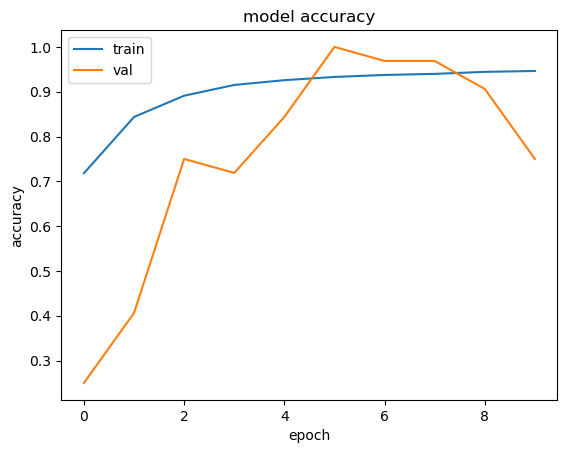

In [9]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

#### Testing
Finally, let's test our model. Here we can define a testing data generator similarly to how we did for out training and validation sets.

In [33]:
test_transform = ImageDataGenerator(rescale=1./255)
test_generator = test_transform.flow_from_directory(
    os.path.join('.', 'archive', 'OCT2017', 'test'),
    target_size = dims,
    batch_size = batch_size,
    class_mode = 'categorical'
)

test_loss, test_acc = model.evaluate(test_generator)
print(f'Test accuracy: {test_acc}') 

Found 968 images belonging to 4 classes.
2/2 [==============================] - 18s 8s/step - loss: 0.1452 - accuracy: 0.9649
Test accuracy: 0.9648760557174683


#### Conclusion
We were able to use TensorFlow to train a convolutional neural network to classify 4 different retinal diseases. Hopefully this provided a good tutorial on how to construct and train a CNN on medical imaging data. For better results and further exploration, one might consider finetuning some of the state of the art image classification models on the data.